In [15]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

/Users/hunglungo/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Package Preparation

In [16]:
# Import packages for scrapping from IOS App Store
from app_store_scraper import AppStore

# Import packages for data processing
import pandas as pd
import numpy as np
import json

# Import packages for topic modelling
# Reference: https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/
import nltk
from nltk import FreqDist

import re
import spacy

import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# text cleaning
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

# Wordcloud of Top N words in each topic
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

# Other pre-setting
pd.set_option("display.max_colwidth", 200)

# Function Preparation

In [17]:
# Function - Scrape review data from App Store
def app_store_scrapperNtransformer(app_name,country,how_many,export_csv_name):
    # Scrape the review data
    fetcher = AppStore(country, app_name)
    fetcher.review(how_many)
    
    # Transform data and put in DataFrame
    transformed_dataframe = pd.DataFrame(np.array(fetcher.reviews),columns=['review'])

    transformed_dataframe = transformed_dataframe.join(pd.DataFrame(transformed_dataframe.pop('review').tolist()))

    transformed_dataframe.to_csv(export_csv_name)

In [18]:
# Function - Plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()
    
# use for flattening out list of lists
def flatten(t):
    return [item for sublist in t for item in sublist]

In [19]:
# Text Cleaning
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

In [20]:
# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    # texts = [bigram_mod[doc] for doc in texts]
    # texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out


In [21]:
# Train LDA models and find optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, chunksize=1000, passes=50)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Scrapping Reviews

In [37]:
app_store_scrapperNtransformer(app_name="Instagram",country="us",
                           how_many=5000,export_csv_name="instagram_data_us.csv")

# Status: Completed

2021-10-17 15:27:12,783 [INFO] Base - Searching for app id
2021-10-17 15:27:15,673 [INFO] Base - Initialised: AppStore('us', 'instagram', 389801252)
2021-10-17 15:27:15,674 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/us/app/instagram/id389801252
2021-10-17 15:27:21,693 [INFO] Base - [id:389801252] Fetched 100 reviews (100 fetched in total)
2021-10-17 15:28:03,100 [ERROR] Base - Something went wrong: HTTPSConnectionPool(host='amp-api.apps.apple.com', port=443): Max retries exceeded with url: /v1/catalog/us/apps/389801252/reviews?l=en-GB&offset=120&limit=20&platform=web&additionalPlatforms=appletv%2Cipad%2Ciphone%2Cmac (Caused by ResponseError('too many 404 error responses'))
2021-10-17 15:28:03,105 [INFO] Base - [id:389801252] Fetched 120 reviews (120 fetched in total)


# Basic Data Preparation

In [12]:
# Import scrapped data
tiktok_ios_us_review = pd.read_csv("instagram_data_us.csv")

In [13]:
# Inspect the data
tiktok_ios_us_review.head()

,Unnamed: 0,isEdited,title,userName,rating,date,review,developerResponse
0,0,False,"Great app, but beware of losing your drafts",yoogabbagabba023,5,2021-04-20 06:58:21,"Overall, I enjoy this app. I’ve been on here since the fall of 2018, I’m a loyal user. However, recently this app was not working properly for me because I was unable to see the instagram icon on ...",NaN
1,1,False,Social Work student here!,Zanna .,3,2021-06-21 23:34:58,"For all of the hype that surrounds TikTok, it is an incredibly interesting app that plays a major role in the life of most adolescents today. It can create unique spaces of community on the app, a...",NaN
2,2,False,It’s amazing! But needs some updates,Musical Spy,5,2021-06-09 05:46:56,"4/5\nMy tiktok experience has been the best! I’ve gotten no hate but it is still possible! So be aware, however it is a really fun app to make videos, react to videos, and find your favorite creat...",NaN
3,3,False,People are getting banned for no reason…..,Jackface22,3,2021-07-24 15:31:30,This app will always have a place in my heart it has helped me through some tough times. Getting on this app everyday and seeing my favorite creator will always make my day. Even when I myself sta...,NaN
4,4,False,One of the best!,TEKEASE,5,2021-09-02 16:57:36,"TikTok has changed the world of social media. It’s not only the most enjoyable platform for general entertainment, it provides a lot of meaningful curated content to the users specific interests. ...",NaN


In [14]:
# Sort by date, only keep data between 2018 and 2021, clean columns
tiktok_ios_us_review_YearMonth = (tiktok_ios_us_review.copy()
                                                      .sort_values(by='date')
                                                      .reset_index()
                                                      .drop(columns=['index','Unnamed: 0'])
                                                      .query("`date` > '2017-12-31 23:59:59' and \
                                                             `date` < '2021-12-31 23:59:59'")
                                     ) 
# Remove time from date column
tiktok_ios_us_review_YearMonth['date'] = pd.to_datetime(tiktok_ios_us_review_YearMonth['date']).dt.floor('d')

# Create year column
tiktok_ios_us_review_YearMonth['year'] = pd.DatetimeIndex(tiktok_ios_us_review_YearMonth['date']).year

# Create month column
tiktok_ios_us_review_YearMonth['month'] = pd.DatetimeIndex(tiktok_ios_us_review_YearMonth['date']).month

In [15]:
# Inspect the dataframe again after cleaning
tiktok_ios_us_review_YearMonth.head()

,isEdited,title,userName,rating,date,review,developerResponse,year,month
0,False,New Update - bad,Jaid3nA,1,2018-05-17,I’ve been using this app for almost 3 years now. The new update that just came out doesn’t let us as muser’s save our audios to use them later. I and many others think that you should change it ba...,NaN,2018,5
1,False,I hate this new update 🤮🤢,please the stickers👏,5,2018-05-18,First of all I can’t use my stickers anymore and I hate that the most and I also hate that they put new filters of cats and dogs musically I hope you hear this because me and 23 of my friends don'...,NaN,2018,5
2,False,Bad quality:(,Rylie2004,5,2018-05-18,I do NOT recommend getting the new\nupdate. It is making people very angry. All the video quality is now bad. It’s blurry and glitchy. But what gets everyone most upset is that you can not use sou...,NaN,2018,5
3,False,The update is terrible!,kawaiipotatofromgermany,5,2018-05-18,"Musically was one of my most used apps. Like seriously, musically, 24/7. But with the new update musically keeps on glitching. I k ow there are a ton of apps the funimate and like. Musicallys new ...",NaN,2018,5
4,False,I'm bothered with the May 17 update.,Danosaur128,2,2018-05-18,I don't post anything ok the app. I follow people and make privates. I have (had) hundreds of privates with memories and just fun-to-do videos made. I updated the app today and my privates have tu...,NaN,2018,5


# EDA

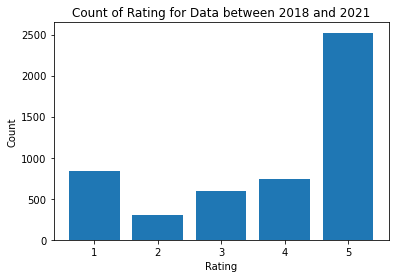

In [16]:
# Plot the count of different ratings for data between 2018 and 2021
tiktok_ios_us_review_score_count = tiktok_ios_us_review_YearMonth.groupby(['rating'])[['review']].nunique().rename(columns={'review':'count'})

plt.bar(tiktok_ios_us_review_score_count.index,tiktok_ios_us_review_score_count['count'])
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Count of Rating for Data between 2018 and 2021")
plt.show()

Text(0.5, 1.0, 'Count of Rating for Each Year between 2018 and 2021')

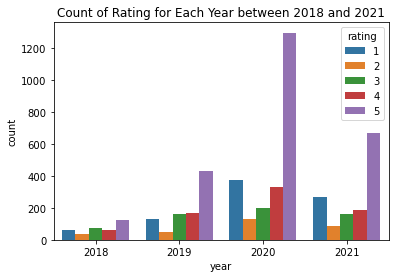

In [17]:
# Plot the count of different ratings for each year
tiktok_ios_us_review_score_count_ByYear = (tiktok_ios_us_review_YearMonth.groupby(['year','rating'])[['review']]
                                                                        .nunique()
                                                                        .rename(columns={'review':'count'})
                                                                        .reset_index()
                                              )

(sns.barplot(data=tiktok_ios_us_review_score_count_ByYear,x='year',y='count',hue='rating')
   .set_title("Count of Rating for Each Year between 2018 and 2021")
)

# Comment: extreme review score on 1 or 5

In [18]:
# Understand average ratings over year
tiktok_ios_us_review_avg_score_ByYear = (tiktok_ios_us_review_YearMonth.groupby(['year'])[['rating']]
                                                                       .mean()
                                              )

tiktok_ios_us_review_avg_score_ByYear['count'] = tiktok_ios_us_review_score_count_ByYear.groupby('year')[['count']].sum().values

print('Average ratings and count of each year:')
tiktok_ios_us_review_avg_score_ByYear

Average ratings and count of each year:


,rating,count
year,,
2018,3.429379,354
2019,3.763326,938
2020,3.877464,2334
2021,3.656477,1374


# Dataframe Preparation for Topic Modelling

In [19]:
# Dataframe with data between 2018 and 2021 without score or year filtering
tiktok_ios_us_review_YearMonth.head()

,isEdited,title,userName,rating,date,review,developerResponse,year,month
0,False,New Update - bad,Jaid3nA,1,2018-05-17,I’ve been using this app for almost 3 years now. The new update that just came out doesn’t let us as muser’s save our audios to use them later. I and many others think that you should change it ba...,NaN,2018,5
1,False,I hate this new update 🤮🤢,please the stickers👏,5,2018-05-18,First of all I can’t use my stickers anymore and I hate that the most and I also hate that they put new filters of cats and dogs musically I hope you hear this because me and 23 of my friends don'...,NaN,2018,5
2,False,Bad quality:(,Rylie2004,5,2018-05-18,I do NOT recommend getting the new\nupdate. It is making people very angry. All the video quality is now bad. It’s blurry and glitchy. But what gets everyone most upset is that you can not use sou...,NaN,2018,5
3,False,The update is terrible!,kawaiipotatofromgermany,5,2018-05-18,"Musically was one of my most used apps. Like seriously, musically, 24/7. But with the new update musically keeps on glitching. I k ow there are a ton of apps the funimate and like. Musicallys new ...",NaN,2018,5
4,False,I'm bothered with the May 17 update.,Danosaur128,2,2018-05-18,I don't post anything ok the app. I follow people and make privates. I have (had) hundreds of privates with memories and just fun-to-do videos made. I updated the app today and my privates have tu...,NaN,2018,5


In [20]:
# Prepare dataframe for topic modelling for each score
# Obtain 5 dataframes with only score=1,2,3,4,5
tiktok_ios_us_review_YearMonth_score1 = tiktok_ios_us_review_YearMonth[tiktok_ios_us_review_YearMonth['rating']==1]
tiktok_ios_us_review_YearMonth_score2 = tiktok_ios_us_review_YearMonth[tiktok_ios_us_review_YearMonth['rating']==2]
tiktok_ios_us_review_YearMonth_score3 = tiktok_ios_us_review_YearMonth[tiktok_ios_us_review_YearMonth['rating']==3]
tiktok_ios_us_review_YearMonth_score4 = tiktok_ios_us_review_YearMonth[tiktok_ios_us_review_YearMonth['rating']==4]
tiktok_ios_us_review_YearMonth_score5 = tiktok_ios_us_review_YearMonth[tiktok_ios_us_review_YearMonth['rating']==5]


In [21]:
# Prepare dataframe for grouped score
tiktok_ios_us_review_YearMonth_score1N2N3 = tiktok_ios_us_review_YearMonth[tiktok_ios_us_review_YearMonth['rating'].isin([1,2,3])]
tiktok_ios_us_review_YearMonth_score4N5 = tiktok_ios_us_review_YearMonth[tiktok_ios_us_review_YearMonth['rating'].isin([4,5])]


In [22]:
# Prepare dataframe for topic modelling for 2018,2019,2020,2021 for score = 1,2,3
tiktok_ios_us_review_YearMonth_2018_score1N2N3 = tiktok_ios_us_review_YearMonth[(tiktok_ios_us_review_YearMonth['year']==2018)&(tiktok_ios_us_review_YearMonth['rating'].isin([1,2,3]))]
tiktok_ios_us_review_YearMonth_2019_score1N2N3 = tiktok_ios_us_review_YearMonth[(tiktok_ios_us_review_YearMonth['year']==2019)&(tiktok_ios_us_review_YearMonth['rating'].isin([1,2,3]))]
tiktok_ios_us_review_YearMonth_2020_score1N2N3 = tiktok_ios_us_review_YearMonth[(tiktok_ios_us_review_YearMonth['year']==2020)&(tiktok_ios_us_review_YearMonth['rating'].isin([1,2,3]))]
tiktok_ios_us_review_YearMonth_2021_score1N2N3 = tiktok_ios_us_review_YearMonth[(tiktok_ios_us_review_YearMonth['year']==2021)&(tiktok_ios_us_review_YearMonth['rating'].isin([1,2,3]))]




# Overall LDA Topic Modelling

In [23]:
# Overall Topic Modelling - data between 2018 and 2021 without score or year filtering
# Convert to list - move to each section
review_us = tiktok_ios_us_review_YearMonth.review.values.tolist()
review_words_us = list(sent_to_words(review_us))
print(review_words_us[:1])

[['ve', 'been', 'using', 'this', 'app', 'for', 'almost', 'years', 'now', 'the', 'new', 'update', 'that', 'just', 'came', 'out', 'doesn', 'let', 'us', 'as', 'muser', 'save', 'our', 'audios', 'to', 'use', 'them', 'later', 'and', 'many', 'others', 'think', 'that', 'you', 'should', 'change', 'it', 'back', 'to', 'what', 'it', 'was', 'or', 'give', 'us', 'the', 'opportunity', 'to', 'save', 'audios', 'and', 'use', 'them', 'later', 'also', 'the', 'way', 'privates', 'are', 'laid', 'out', 'are', 'extremely', 'different', 'from', 'what', 'it', 'used', 'to', 'be', 'so', 'if', 'you', 'could', 'do', 'anything', 'about', 'this', 'really', 'hope', 'you', 'would', 'thank', 'you', 'have', 'couple', 'more', 'things', 'to', 'say', 'in', 'my', 'opinion', 'and', 'probably', 'many', 'others', 'to', 'we', 'don', 'enjoy', 'this', 'new', 'update', 'at', 'all', 'the', 'way', 'everything', 'is', 'laid', 'out', 'is', 'really', 'different', 'am', 'not', 'the', 'biggest', 'fan', 'of', 'it', 'not', 'one', 'that', 'big

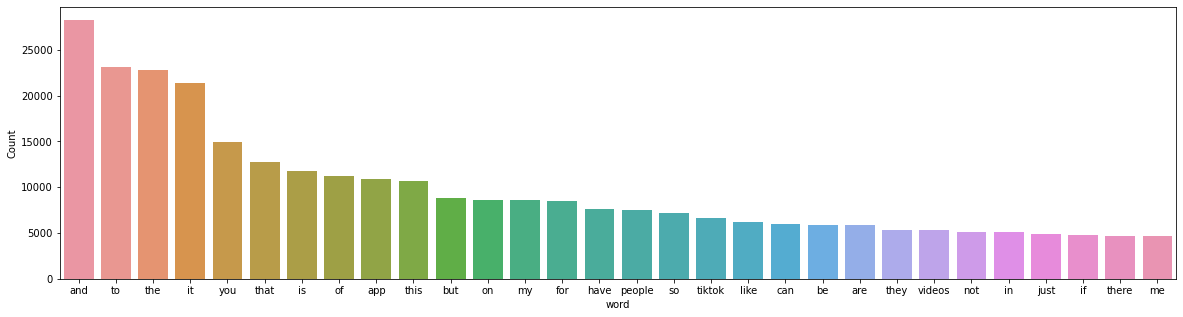

In [24]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us))

In [25]:
# Clean text
review_us_ready = process_words(review_words_us)  # processed Text Data! - move to each section

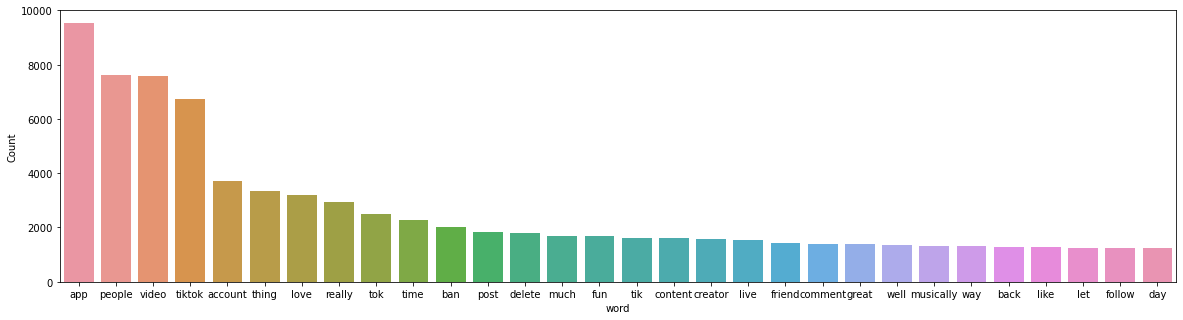

In [26]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_us_ready))

In [27]:
# Create Dictionary
id2word_us = corpora.Dictionary(review_us_ready)

In [28]:
# Create Corpus: Term Document Frequency
corpus_us = [id2word_us.doc2bow(text) for text in review_us_ready]

In [29]:
# Training LDA model
model_list_us, coherence_values_us = compute_coherence_values(dictionary=id2word_us, corpus=corpus_us, 
                                                              texts=review_us_ready, limit=30, start=2, step=5)

# Time Start: 03:44
# Time End: 
# Time Used: 

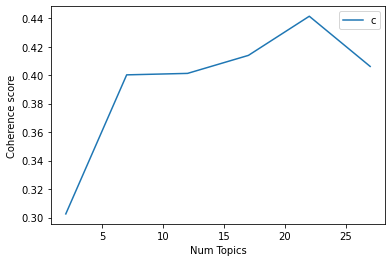

In [30]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [31]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 22

index: 0 | Num Topics = 2  has Coherence Value of 0.3026
index: 1 | Num Topics = 7  has Coherence Value of 0.4002
index: 2 | Num Topics = 12  has Coherence Value of 0.4012
index: 3 | Num Topics = 17  has Coherence Value of 0.4139
index: 4 | Num Topics = 22  has Coherence Value of 0.4414
index: 5 | Num Topics = 27  has Coherence Value of 0.4061


In [166]:
# Select optimal number of topics
optimal_model_us = model_list_us[4]

In [167]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us = pyLDAvis.gensim_models.prepare(optimal_model_us, corpus_us, id2word_us)

In [169]:
print("pyLDAVis for overall us topics:")
vis_us

pyLDAVis for overall us topics:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.260142  0.033910       1        1  18.739791
8      0.119911 -0.162325       2        1  10.599540
11     0.172081  0.104089       3        1   9.664631
17     0.229176 -0.024184       4        1   9.291671
10     0.174291 -0.071407       5        1   8.235138
15     0.161048  0.115970       6        1   6.825922
18     0.210491  0.059361       7        1   6.135206
5      0.158173  0.139813       8        1   5.175753
12     0.053159 -0.235254       9        1   3.981920
7      0.111415 -0.008615      10        1   3.869412
13     0.111640  0.099470      11        1   3.387952
14     0.069284  0.116829      12        1   2.991641
9     -0.044075 -0.250280      13        1   2.445448
6     -0.037218 -0.257061      14        1   2.240606
20    -0.024437  0.072214      15        1   2.151919
4     -0.149824  0.034882      16        1   1.288520
3     -0.234065  0.012733      17        1   0.863942
16    -0.263786  0.047626      18        1   0.492070
21    -0.269203  0.038000      19        1   0.479103
2     -0.252721  0.045935      20        1   0.461303
19    -0.276121  0.043161      21        1   0.362220
1     -0.279359  0.045133      22        1   0.316289, topic_info=          Term         Freq        Total Category  logprob  loglift
72       video  7785.000000  7785.000000  Default  30.0000  30.0000
316    account  3786.000000  3786.000000  Default  29.0000  29.0000
1251       tok  2522.000000  2522.000000  Default  28.0000  28.0000
65      people  7856.000000  7856.000000  Default  27.0000  27.0000
136    comment  1395.000000  1395.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
2058  unfollow     9.163765    29.219577  Topic22  -4.5605   4.5967
1001  tutorial     3.742542    36.421983  Topic22  -5.4560   3.4809
395     choice     5.315407    74.769307  Topic22  -5.1051   3.1125
2516  progress     2.487786    24.309306  Topic22  -5.8644   3.4768
1667      tiny     2.562839    33.539000  Topic22  -5.8346   3.1847

[1314 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3235     17  0.813609   abandon
1759      1  0.122402   ability
1759      2  0.812301   ability
1759     18  0.055637   ability
437       1  0.098474      able
...     ...       ...       ...
492       6  0.829222     young
492       7  0.061998     young
1776      8  0.937550  youtuber
3259     14  0.580889      zody
3149      2  0.961615       zoe

[2556 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 9, 12, 18, 11, 16, 19, 6, 13, 8, 14, 15, 10, 7, 21, 5, 4, 17, 22, 3, 20, 2])

# By-rating LDA Topic Modelling

## LDA Topic Modelling (Rating = 1)

In [35]:
# By-rating Topic Modelling - rating = 1
# Convert to list - move to each section
review_us_score1 = tiktok_ios_us_review_YearMonth_score1.review.values.tolist()
review_words_us_score1 = list(sent_to_words(review_us_score1))
print(review_words_us_score1[:1])

[['ve', 'been', 'using', 'this', 'app', 'for', 'almost', 'years', 'now', 'the', 'new', 'update', 'that', 'just', 'came', 'out', 'doesn', 'let', 'us', 'as', 'muser', 'save', 'our', 'audios', 'to', 'use', 'them', 'later', 'and', 'many', 'others', 'think', 'that', 'you', 'should', 'change', 'it', 'back', 'to', 'what', 'it', 'was', 'or', 'give', 'us', 'the', 'opportunity', 'to', 'save', 'audios', 'and', 'use', 'them', 'later', 'also', 'the', 'way', 'privates', 'are', 'laid', 'out', 'are', 'extremely', 'different', 'from', 'what', 'it', 'used', 'to', 'be', 'so', 'if', 'you', 'could', 'do', 'anything', 'about', 'this', 'really', 'hope', 'you', 'would', 'thank', 'you', 'have', 'couple', 'more', 'things', 'to', 'say', 'in', 'my', 'opinion', 'and', 'probably', 'many', 'others', 'to', 'we', 'don', 'enjoy', 'this', 'new', 'update', 'at', 'all', 'the', 'way', 'everything', 'is', 'laid', 'out', 'is', 'really', 'different', 'am', 'not', 'the', 'biggest', 'fan', 'of', 'it', 'not', 'one', 'that', 'big

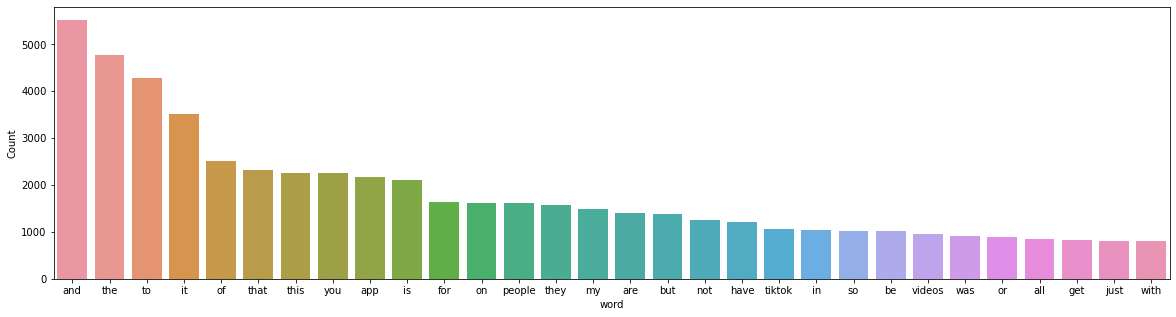

In [36]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_score1))

In [37]:
# Clean text
review_us_ready_score1 = process_words(review_words_us_score1)  # processed Text Data! - move to each section


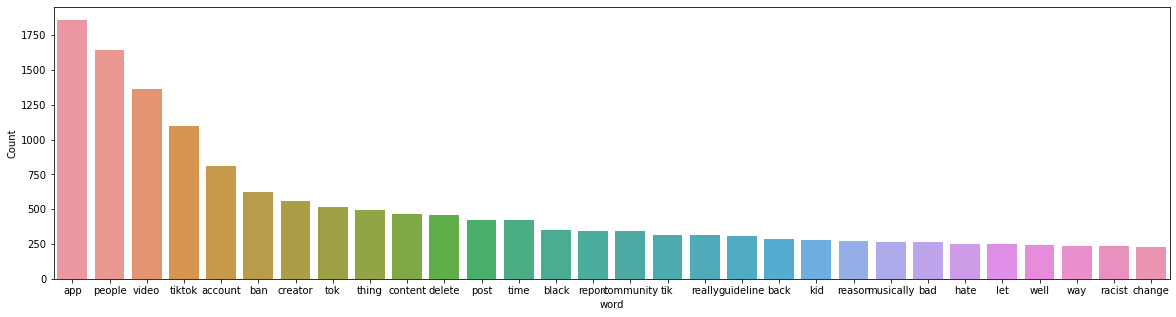

In [38]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_us_ready_score1))


In [39]:
# Create Dictionary
id2word_us_score1 = corpora.Dictionary(review_us_ready_score1)

In [40]:
# Create Corpus: Term Document Frequency
corpus_us_score1 = [id2word_us_score1.doc2bow(text) for text in review_us_ready_score1]

In [41]:
# Training LDA model
model_list_us_score1, coherence_values_us_score1 = compute_coherence_values(dictionary=id2word_us_score1, corpus=corpus_us_score1, 
                                                              texts=review_us_ready_score1, limit=30, start=2, step=5)


In [42]:
%store model_list_us_score1
%store coherence_values_us_score1

Stored 'model_list_us_score1' (list)
Stored 'coherence_values_us_score1' (list)


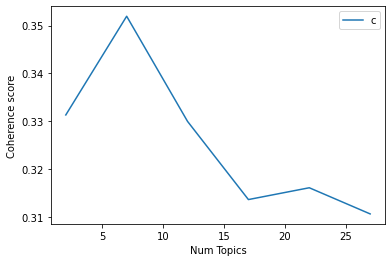

In [43]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_score1)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [44]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_score1):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 7

index: 0 | Num Topics = 2  has Coherence Value of 0.3313
index: 1 | Num Topics = 7  has Coherence Value of 0.3519
index: 2 | Num Topics = 12  has Coherence Value of 0.33
index: 3 | Num Topics = 17  has Coherence Value of 0.3137
index: 4 | Num Topics = 22  has Coherence Value of 0.3161
index: 5 | Num Topics = 27  has Coherence Value of 0.3107


In [170]:
# Select optimal number of topics
optimal_model_us_score1 = model_list_us_score1[1]

In [12]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_score1 = pyLDAvis.gensim_models.prepare(optimal_model_us_score1, corpus_us_score1, id2word_us_score1)

/Users/hunglungo/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'optimal_model_us_score1' is not defined

In [11]:
print("pyLDAVis for us topics for score=1:")
vis_us_score1

pyLDAVis for us topics for score=1:


/Users/hunglungo/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'vis_us_score1' is not defined

## LDA Topic Modelling (Rating = 2)

In [48]:
# By-rating Topic Modelling - rating = 2
# Convert to list - move to each section
review_us_score2 = tiktok_ios_us_review_YearMonth_score2.review.values.tolist()
review_words_us_score2 = list(sent_to_words(review_us_score2))
print(review_words_us_score2[:1])

[['dont', 'post', 'anything', 'ok', 'the', 'app', 'follow', 'people', 'and', 'make', 'privates', 'have', 'had', 'hundreds', 'of', 'privates', 'with', 'memories', 'and', 'just', 'fun', 'to', 'do', 'videos', 'made', 'updated', 'the', 'app', 'today', 'and', 'my', 'privates', 'have', 'turned', 'into', 'drafts', 'which', 'basically', 'means', 'cant', 'reuse', 'sounds', 'have', 'previously', 'used', 'before', 'the', 'recent', 'update', 'meaning', 'all', 'of', 'my', 'privates', 'ranging', 'in', 'at', 'least', 'the', 'hundreds', 'are', 'simply', 'videos', 'that', 'cant', 'reuse', 'or', 'even', 'save', 'to', 'my', 'camera', 'roll', 'without', 'posting', 'the', 'video', 'publicly', 'which', 'refuse', 'to', 'since', 'they', 'are', 'personal', 'videos', 'not', 'meant', 'for', 'others', 'to', 'see', 'when', 'trying', 'to', 'solve', 'the', 'problem', 'with', 'my', 'privates', 'the', 'videos', 'watch', 'to', 'decide', 'if', 'delete', 'them', 'or', 'not', 'end', 'up', 'being', 'duplicated', 'to', 'the

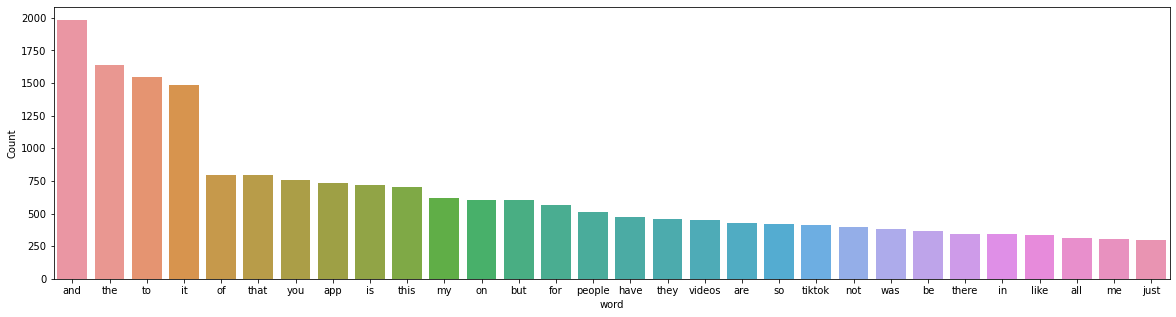

In [49]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_score2))

In [50]:
# Clean text
review_us_ready_score2 = process_words(review_words_us_score2)  # processed Text Data! - move to each section


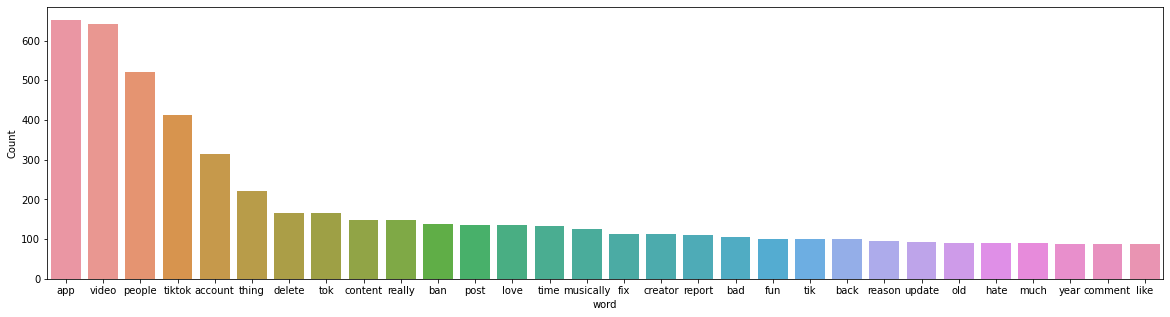

In [51]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_us_ready_score2))


In [52]:
# Create Dictionary
id2word_us_score2 = corpora.Dictionary(review_us_ready_score2)

In [53]:
# Create Corpus: Term Document Frequency
corpus_us_score2 = [id2word_us_score2.doc2bow(text) for text in review_us_ready_score2]

In [54]:
# Training LDA model
model_list_us_score2, coherence_values_us_score2 = compute_coherence_values(dictionary=id2word_us_score2, corpus=corpus_us_score2, 
                                                              texts=review_us_ready_score2, limit=30, start=2, step=5)


In [55]:
%store model_list_us_score2
%store coherence_values_us_score2

Stored 'model_list_us_score2' (list)
Stored 'coherence_values_us_score2' (list)


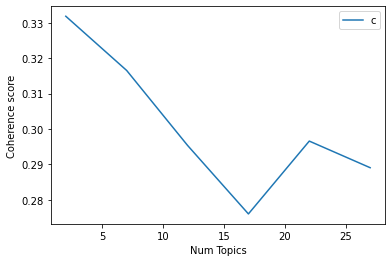

In [56]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_score2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [57]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_score2):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 2

index: 0 | Num Topics = 2  has Coherence Value of 0.3318
index: 1 | Num Topics = 7  has Coherence Value of 0.3165
index: 2 | Num Topics = 12  has Coherence Value of 0.2954
index: 3 | Num Topics = 17  has Coherence Value of 0.2761
index: 4 | Num Topics = 22  has Coherence Value of 0.2966
index: 5 | Num Topics = 27  has Coherence Value of 0.2891


In [173]:
# Select optimal number of topics
optimal_model_us_score2 = model_list_us_score2[0]

In [174]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_score2 = pyLDAvis.gensim_models.prepare(optimal_model_us_score2, corpus_us_score2, id2word_us_score2)

In [175]:
print("pyLDAVis for us topics for score=2:")
vis_us_score2

pyLDAVis for us topics for score=2:


PreparedData(topic_coordinates=             x    y  topics  cluster      Freq
topic                                         
1      0.06441  0.0       1        1  64.45271
0     -0.06441  0.0       2        1  35.54729, topic_info=          Term        Freq       Total Category  logprob  loglift
459        tok  142.000000  142.000000  Default  30.0000  30.0000
23   musically  107.000000  107.000000  Default  29.0000  29.0000
458        tik   87.000000   87.000000  Default  28.0000  28.0000
122        bad   92.000000   92.000000  Default  27.0000  27.0000
27      people  461.000000  461.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
86        time   36.356143  117.998914   Topic2  -5.2420  -0.1430
538     tiktok   52.056534  370.535464   Topic2  -4.8830  -0.9283
97         fix   34.005107  101.893213   Topic2  -5.3089  -0.0631
341      still   31.199840   78.598236   Topic2  -5.3950   0.1104
30        post   31.828739  121.844506   Topic2  -5.3750  -0.3081

[166 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
61        1  0.902522  account
61        2  0.099100  account
612       1  0.187082      age
612       2  0.816357      age
0         1  0.625249      app
...     ...       ...      ...
424       2  0.139604    wrong
60        1  0.561198     year
60        2  0.446408     year
835       1  0.323958    young
835       2  0.677366    young

[215 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

## LDA Topic Modelling (Rating = 3)

In [61]:
# By-rating Topic Modelling - rating = 3
# Convert to list - move to each section
review_us_score3 = tiktok_ios_us_review_YearMonth_score3.review.values.tolist()
review_words_us_score3 = list(sent_to_words(review_us_score3))
print(review_words_us_score3[:1])

[['being', 'honest', 'absolutely', 'hate', 'the', 'new', 'update', 'have', 'been', 'on', 'musically', 'for', 'years', 'now', 'and', 'this', 'is', 'definitely', 'the', 'worst', 'update', 'yet', 'the', 'overall', 'composition', 'of', 'the', 'face', 'when', 'your', 'watching', 'the', 'videos', 'is', 'not', 'pretty', 'and', 'the', 'new', 'profile', 'setup', 'is', 'very', 'disappointing', 'being', 'honest', 'loved', 'the', 'old', 'update', 'loved', 'loved', 'loved', 'the', 'badges', 'and', 'then', 'poof', 'their', 'gone', 'can', 'really', 'see', 'why', 'people', 'are', 'leaving', 'this', 'app', 'musically', 'keeps', 'crashing', 'and', 'glitching', 'for', 'me', 'and', 'the', 'setup', 'to', 'post', 'video', 'is', 'very', 'confusing', 'now', 'and', 'why', 'can', 'we', 'promote', 'any', 'comments', 'anymore', 'we', 'need', 'that', 'because', 'for', 'the', 'people', 'who', 'want', 'to', 'tell', 'their', 'fans', 'things', 'in', 'the', 'comments', 'they', 'want', 'to', 'promote', 'the', 'comments'

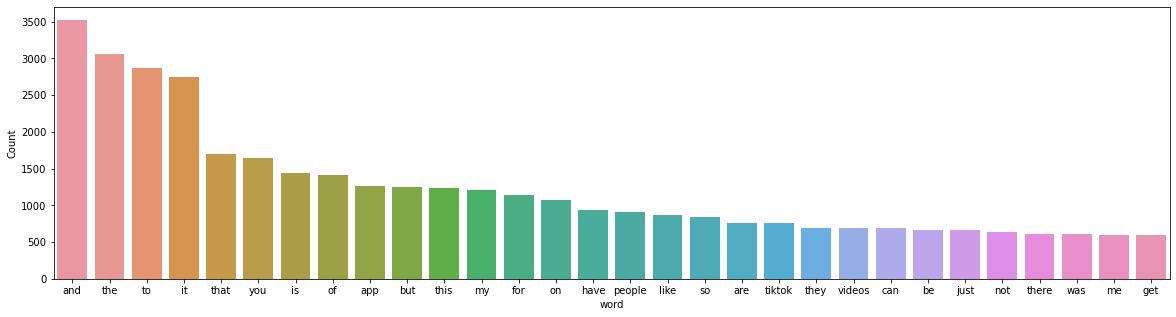

In [62]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_score3))

In [63]:
# Clean text
review_us_ready_score3 = process_words(review_words_us_score3)  # processed Text Data! - move to each section


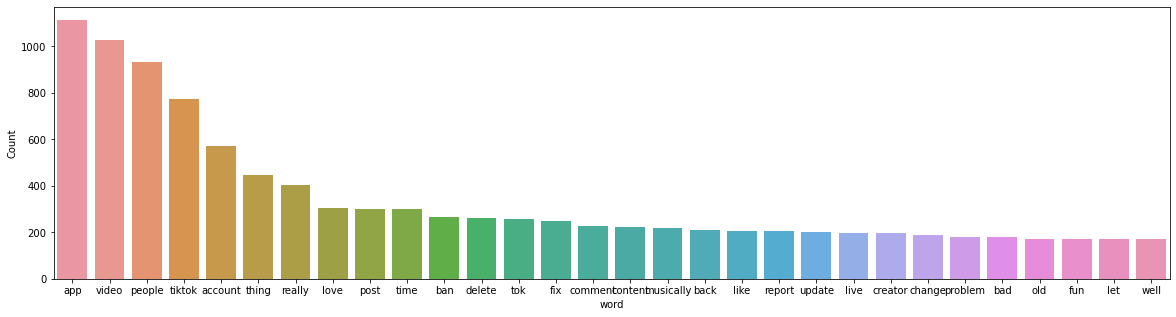

In [64]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_us_ready_score3))


In [65]:
# Create Dictionary
id2word_us_score3 = corpora.Dictionary(review_us_ready_score3)

In [66]:
# Create Corpus: Term Document Frequency
corpus_us_score3 = [id2word_us_score3.doc2bow(text) for text in review_us_ready_score3]

In [67]:
# Training LDA model
model_list_us_score3, coherence_values_us_score3 = compute_coherence_values(dictionary=id2word_us_score3, corpus=corpus_us_score3, 
                                                              texts=review_us_ready_score3, limit=30, start=2, step=5)


In [68]:
%store model_list_us_score3
%store coherence_values_us_score3

Stored 'model_list_us_score3' (list)
Stored 'coherence_values_us_score3' (list)


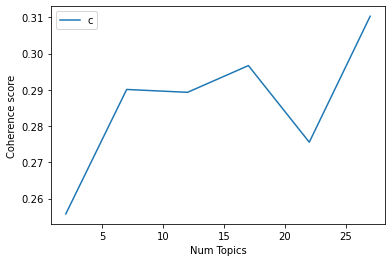

In [69]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_score3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [70]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_score3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.2558
index: 1 | Num Topics = 7  has Coherence Value of 0.2901
index: 2 | Num Topics = 12  has Coherence Value of 0.2893
index: 3 | Num Topics = 17  has Coherence Value of 0.2967
index: 4 | Num Topics = 22  has Coherence Value of 0.2756
index: 5 | Num Topics = 27  has Coherence Value of 0.3103


In [71]:
# Select optimal number of topics
optimal_model_us_score3 = model_list_us_score3[5]

In [72]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_score3 = pyLDAvis.gensim_models.prepare(optimal_model_us_score3, corpus_us_score3, id2word_us_score3)

In [73]:
print("pyLDAVis for us topics for score=3:")
vis_us_score3

pyLDAVis for us topics for score=3:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.099064 -0.063778       1        1  10.798335
15    -0.102467  0.052489       2        1   9.797296
19    -0.097159 -0.006573       3        1   7.165621
13    -0.091031  0.124241       4        1   6.342533
14    -0.073354 -0.131628       5        1   5.873213
1     -0.082051 -0.043569       6        1   5.847875
12    -0.065080 -0.039852       7        1   5.747583
3     -0.087757  0.001310       8        1   5.191750
0     -0.049199 -0.031396       9        1   5.165597
23    -0.055870 -0.059035      10        1   4.706758
16    -0.119468  0.105311      11        1   4.560703
20    -0.061942  0.043720      12        1   3.760575
2     -0.021052  0.104622      13        1   2.953382
21     0.000010 -0.078305      14        1   2.704236
25    -0.035480  0.000642      15        1   2.588888
10     0.007993  0.070325      16        1   2.402533
7     -0.006335 -0.074943      17        1   2.279017
22     0.033893 -0.111633      18        1   1.897146
8     -0.001269  0.021598      19        1   1.751115
24     0.039665  0.016848      20        1   1.711518
26     0.050076  0.050990      21        1   1.646424
18     0.047110 -0.004557      22        1   1.507771
6      0.056502  0.040780      23        1   1.311808
4      0.149361 -0.052486      24        1   0.836811
9      0.181907  0.073847      25        1   0.691934
11     0.205602 -0.014733      26        1   0.637864
17     0.276458  0.005764      27        1   0.121715, topic_info=          Term         Freq        Total Category  logprob  loglift
195    account   537.000000   537.000000  Default  30.0000  30.0000
24   musically   207.000000   207.000000  Default  29.0000  29.0000
2          app  1029.000000  1029.000000  Default  28.0000  28.0000
39      update   189.000000   189.000000  Default  27.0000  27.0000
28      people   875.000000   875.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
26         old     0.011632   159.434054  Topic27  -8.1984  -2.8144
2          app     0.011631  1029.226770  Topic27  -8.1984  -4.6794
729       mine     0.011631    10.406915  Topic27  -8.1984  -0.0853
139      draft     0.011629    68.382437  Topic27  -8.1986  -1.9681
42        year     0.011629   120.609666  Topic27  -8.1986  -2.5356

[1999 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1605     23  0.596140      abb
662      16  0.573937    abide
789       1  0.091812  ability
789       7  0.642687  ability
789      19  0.091812  ability
...     ...       ...      ...
219      22  0.047660    young
219      26  0.015887    young
2565      1  0.722994  younger
441       2  0.718964    youth
2761      3  0.728578      zoe

[5470 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 16, 20, 14, 15, 2, 13, 4, 1, 24, 17, 21, 3, 22, 26, 11, 8, 23, 9, 25, 27, 19, 7, 5, 10, 12, 18])

## LDA Topic Modelling (Rating = 4)

In [74]:
# By-rating Topic Modelling - rating = 4
# Convert to list - move to each section
review_us_score4 = tiktok_ios_us_review_YearMonth_score4.review.values.tolist()
review_words_us_score4 = list(sent_to_words(review_us_score4))
print(review_words_us_score4[2:3])

[['would', 'rate', 'this', 'app', 'zero', 'stars', 'if', 'could', 'musically', 'keeps', 'updating', 'their', 'app', 'and', 'no', 'one', 'likes', 'the', 'new', 'updates', 'they', 'are', 'terrible', 'and', 'ruining', 'the', 'app', 'you', 'used', 'to', 'be', 'able', 'to', 'add', 'in', 'emoji', 'stickers', 'on', 'your', 'musically', 'video', 'and', 'now', 'you', 'can', 'there', 'are', 'also', 'ton', 'of', 'other', 'things', 'wrong', 'if', 'you', 'go', 'on', 'musically', 'official', 'account', 'on', 'musically', 'you', 'can', 'see', 'people', 'commenting', 'on', 'all', 'of', 'their', 'videos', 'saying', 'things', 'like', 'fix', 'your', 'app', 'and', 'change', 'it', 'back', 'to', 'before', 'the', 'update', 'and', 'those', 'are', 'some', 'of', 'the', 'nicer', 'comments', 'musers', 'users', 'of', 'musically', 'are', 'not', 'happy', 'not', 'to', 'mention', 'all', 'the', 'glitches', 'that', 'are', 'going', 'on', 'they', 'changed', 'the', 'character', 'limit', 'for', 'commenting', 'on', 'people',

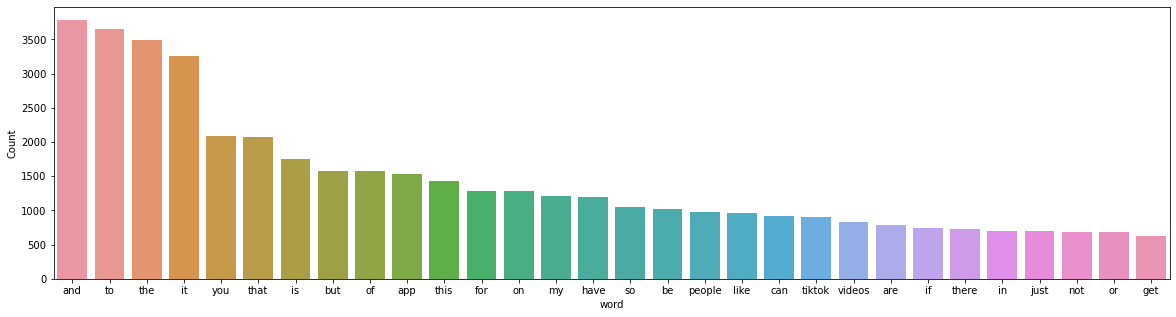

In [75]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_score4))

In [76]:
# Clean text
review_us_ready_score4 = process_words(review_words_us_score4)  # processed Text Data! - move to each section

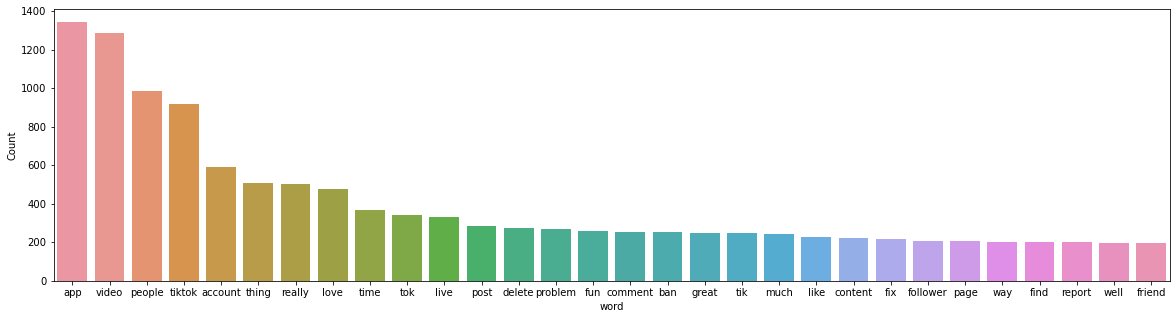

In [77]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_us_ready_score4))


In [78]:
# Create Dictionary
id2word_us_score4 = corpora.Dictionary(review_us_ready_score4)

In [79]:
# Create Corpus: Term Document Frequency
corpus_us_score4 = [id2word_us_score4.doc2bow(text) for text in review_us_ready_score4]

In [80]:
# Training LDA model
model_list_us_score4, coherence_values_us_score4 = compute_coherence_values(dictionary=id2word_us_score4, corpus=corpus_us_score4, 
                                                              texts=review_us_ready_score4, limit=30, start=2, step=5)


In [81]:
%store model_list_us_score4
%store coherence_values_us_score4

Stored 'model_list_us_score4' (list)
Stored 'coherence_values_us_score4' (list)


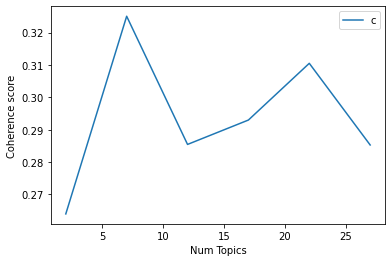

In [82]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_score4)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [83]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_score4):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics =  7

index: 0 | Num Topics = 2  has Coherence Value of 0.264
index: 1 | Num Topics = 7  has Coherence Value of 0.3251
index: 2 | Num Topics = 12  has Coherence Value of 0.2854
index: 3 | Num Topics = 17  has Coherence Value of 0.293
index: 4 | Num Topics = 22  has Coherence Value of 0.3105
index: 5 | Num Topics = 27  has Coherence Value of 0.2853


In [176]:
# Select optimal number of topics
optimal_model_us_score4 = model_list_us_score4[1]

In [177]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_score4 = pyLDAvis.gensim_models.prepare(optimal_model_us_score4, corpus_us_score4, id2word_us_score4)

In [178]:
print("pyLDAVis for us topics for score=4:")
vis_us_score4

pyLDAVis for us topics for score=4:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.076241 -0.006914       1        1  23.339642
6      0.006489  0.077040       2        1  21.094881
4      0.026380 -0.049609       3        1  18.215475
0      0.064645  0.127542       4        1  15.150340
2      0.029074 -0.080533       5        1  11.827980
3      0.034237 -0.075841       6        1   8.842026
1     -0.237066  0.008315       7        1   1.529656, topic_info=         Term        Freq       Total Category  logprob  loglift
63     people  910.000000  910.000000  Default  30.0000  30.0000
50    account  553.000000  553.000000  Default  29.0000  29.0000
265      live  312.000000  312.000000  Default  28.0000  28.0000
616       ban  230.000000  230.000000  Default  27.0000  27.0000
309       kid  143.000000  143.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
18       much    2.933609  228.838985   Topic7  -5.3410  -0.1767
541   content    2.840116  206.560319   Topic7  -5.3734  -0.1066
63     people    3.165909  910.602155   Topic7  -5.2648  -1.4815
111  actually    2.431419   71.147146   Topic7  -5.5288   0.8039
74       user    2.407323  114.748935   Topic7  -5.5387   0.3159

[539 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.473279      able
0         2  0.228087      able
0         3  0.091235      able
0         4  0.079830      able
0         5  0.045617      able
...     ...       ...       ...
49        6  0.123316      year
321       2  0.029350     young
321       3  0.851137     young
321       5  0.117398     young
1459      4  0.805218  youtuber

[1125 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 5, 1, 3, 4, 2])

## LDA Topic Modelling (Rating = 5)

In [87]:
# By-rating Topic Modelling - rating = 5
# Convert to list - move to each section
review_us_score5 = tiktok_ios_us_review_YearMonth_score5.review.values.tolist()
review_words_us_score5 = list(sent_to_words(review_us_score5))
print(review_words_us_score5[:1])

[['first', 'of', 'all', 'can', 'use', 'my', 'stickers', 'anymore', 'and', 'hate', 'that', 'the', 'most', 'and', 'also', 'hate', 'that', 'they', 'put', 'new', 'filters', 'of', 'cats', 'and', 'dogs', 'musically', 'hope', 'you', 'hear', 'this', 'because', 'me', 'and', 'of', 'my', 'friends', 'dont', 'like', 'this', 'we', 'would', 'appreciate', 'if', 'you', 'could', 'bring', 'back', 'the', 'stickers', 'and', 'if', 'you', 'can', 'also', 'change', 'the', 'drafts', 'thing', 'because', 'liked', 'it', 'as', 'privates', 'because', 'you', 'just', 'had', 'to', 'scroll', 'and', 'now', 'you', 'have', 'to', 'press', 'on', 'one', 'then', 'get', 'out', 'and', 'don', 'like', 'it', 'pleas', 'hear', 'this', 'and', 'just', 'hate', 'it', 'so', 'much', 'that', 'can', 'have', 'my', 'stickers', 'at', 'all', 'ugh', 'please', 'bring', 'the', 'stickers', 'back', 'please']]


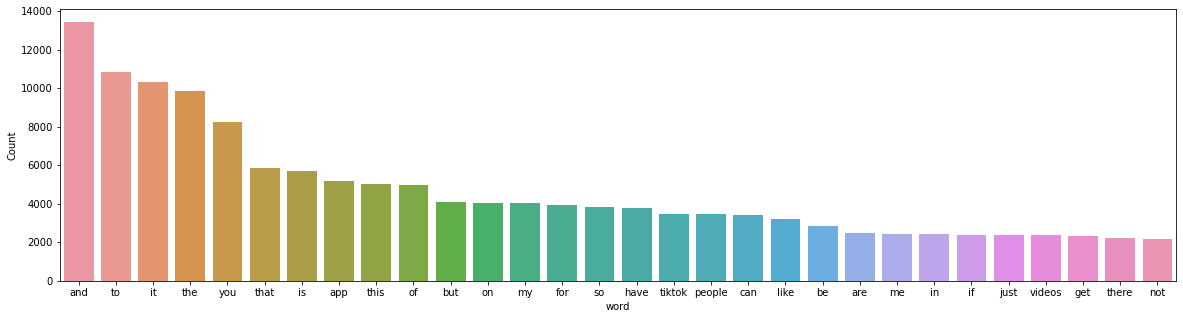

In [88]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_score5))

In [89]:
# Clean text
review_us_ready_score5 = process_words(review_words_us_score5)  # processed Text Data! - move to each section

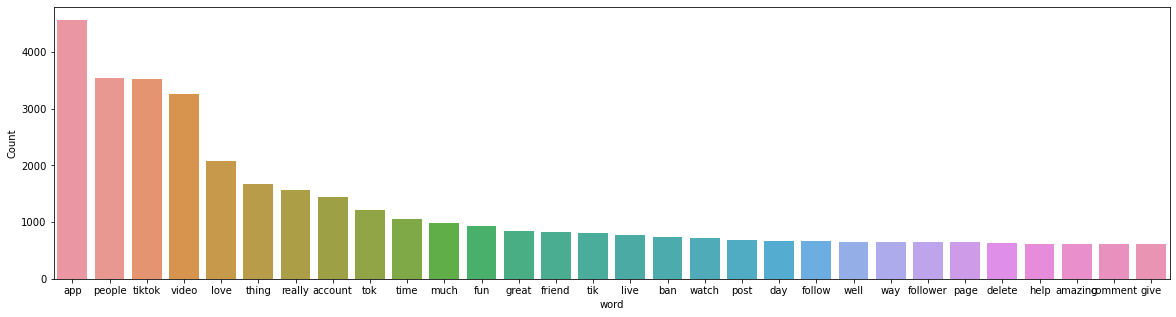

In [90]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_us_ready_score5))


In [91]:
# Create Dictionary
id2word_us_score5 = corpora.Dictionary(review_us_ready_score5)

In [92]:
# Create Corpus: Term Document Frequency
corpus_us_score5 = [id2word_us_score5.doc2bow(text) for text in review_us_ready_score5]

In [93]:
# Training LDA model
model_list_us_score5, coherence_values_us_score5 = compute_coherence_values(dictionary=id2word_us_score5, corpus=corpus_us_score5, 
                                                              texts=review_us_ready_score5, limit=30, start=2, step=5)


In [94]:
%store model_list_us_score5
%store coherence_values_us_score5

Stored 'model_list_us_score5' (list)
Stored 'coherence_values_us_score5' (list)


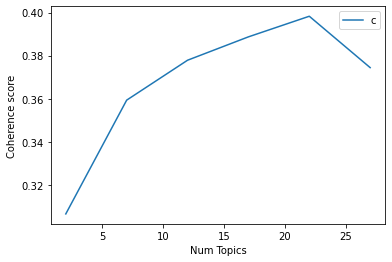

In [95]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_score5)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [96]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_score5):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 22

index: 0 | Num Topics = 2  has Coherence Value of 0.3065
index: 1 | Num Topics = 7  has Coherence Value of 0.3593
index: 2 | Num Topics = 12  has Coherence Value of 0.3779
index: 3 | Num Topics = 17  has Coherence Value of 0.3887
index: 4 | Num Topics = 22  has Coherence Value of 0.3983
index: 5 | Num Topics = 27  has Coherence Value of 0.3744


In [179]:
# Select optimal number of topics
optimal_model_us_score5 = model_list_us_score5[4]

In [180]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_score5 = pyLDAvis.gensim_models.prepare(optimal_model_us_score5, corpus_us_score5, id2word_us_score5)

In [182]:
print("pyLDAVis for us topics for score=5:")
vis_us_score5

pyLDAVis for us topics for score=5:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.296184 -0.034568       1        1  27.878610
19    -0.255068  0.005652       2        1  13.130944
3     -0.276933 -0.053644       3        1  12.684159
15    -0.273748  0.153391       4        1   9.768870
13    -0.237615 -0.088190       5        1   7.610481
18    -0.236450 -0.074730       6        1   7.448657
1     -0.062847  0.042574       7        1   3.743090
2     -0.100187  0.296470       8        1   2.927302
12    -0.063777 -0.184140       9        1   2.633738
8      0.008351  0.164595      10        1   2.368597
14    -0.021953 -0.188451      11        1   2.121577
4      0.078410 -0.037953      12        1   1.458077
10     0.117609  0.033836      13        1   1.028206
11     0.138632  0.001192      14        1   0.909849
16     0.163762 -0.006102      15        1   0.877618
5      0.176762  0.016119      16        1   0.733044
17     0.158358 -0.023077      17        1   0.727662
20     0.169904 -0.018050      18        1   0.672638
0      0.182536  0.015630      19        1   0.537878
9      0.210087 -0.002329      20        1   0.328617
6      0.211332 -0.007197      21        1   0.218285
21     0.209018 -0.011030      22        1   0.192099, topic_info=             Term         Freq        Total Category  logprob  loglift
47          video  3284.000000  3284.000000  Default  30.0000  30.0000
646           tok  1163.000000  1163.000000  Default  29.0000  29.0000
652           tik   747.000000   747.000000  Default  28.0000  28.0000
1189          ban   717.000000   717.000000  Default  27.0000  27.0000
37         people  3481.000000  3481.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
4985  transparent     0.026613     0.911519  Topic22  -9.1187   2.7212
4000         fool     0.026613     0.911520  Topic22  -9.1187   2.7212
3408       remain     0.026613     0.911520  Topic22  -9.1187   2.7212
769        cousin     0.558458    36.181008  Topic22  -6.0749   2.0838
853           man     0.637143    76.909456  Topic22  -5.9431   1.4615

[1257 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
343       1  0.158046   able
343       2  0.067734   able
343       3  0.101601   able
343       4  0.550902   able
343       5  0.042898   able
...     ...       ...    ...
247       5  0.120575  young
247       6  0.829555  young
336      19  0.168334     yr
336      22  0.673334     yr
433      21  0.723372   zoom

[2284 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 20, 4, 16, 14, 19, 2, 3, 13, 9, 15, 5, 11, 12, 17, 6, 18, 21, 1, 10, 7, 22])

## LDA Topic Modelling (Rating = 1,2,3)

In [100]:
# By-rating Topic Modelling - rating = 1,2,3
# Convert to list - move to each section
review_us_score1N2N3 = tiktok_ios_us_review_YearMonth_score1N2N3.review.values.tolist()
review_words_us_score1N2N3 = list(sent_to_words(review_us_score1N2N3))
print(review_words_us_score1N2N3[:1])

[['ve', 'been', 'using', 'this', 'app', 'for', 'almost', 'years', 'now', 'the', 'new', 'update', 'that', 'just', 'came', 'out', 'doesn', 'let', 'us', 'as', 'muser', 'save', 'our', 'audios', 'to', 'use', 'them', 'later', 'and', 'many', 'others', 'think', 'that', 'you', 'should', 'change', 'it', 'back', 'to', 'what', 'it', 'was', 'or', 'give', 'us', 'the', 'opportunity', 'to', 'save', 'audios', 'and', 'use', 'them', 'later', 'also', 'the', 'way', 'privates', 'are', 'laid', 'out', 'are', 'extremely', 'different', 'from', 'what', 'it', 'used', 'to', 'be', 'so', 'if', 'you', 'could', 'do', 'anything', 'about', 'this', 'really', 'hope', 'you', 'would', 'thank', 'you', 'have', 'couple', 'more', 'things', 'to', 'say', 'in', 'my', 'opinion', 'and', 'probably', 'many', 'others', 'to', 'we', 'don', 'enjoy', 'this', 'new', 'update', 'at', 'all', 'the', 'way', 'everything', 'is', 'laid', 'out', 'is', 'really', 'different', 'am', 'not', 'the', 'biggest', 'fan', 'of', 'it', 'not', 'one', 'that', 'big

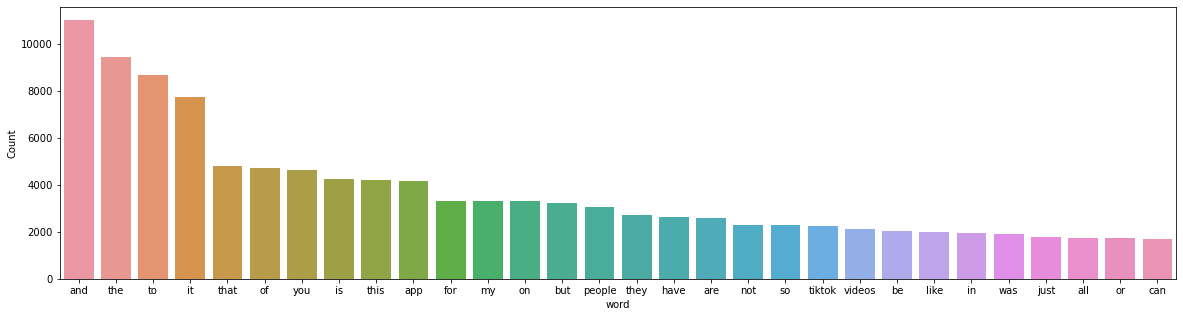

In [101]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_score1N2N3))

In [102]:
# Clean text
review_us_ready_score1N2N3 = process_words(review_words_us_score1N2N3)  # processed Text Data! - move to each section

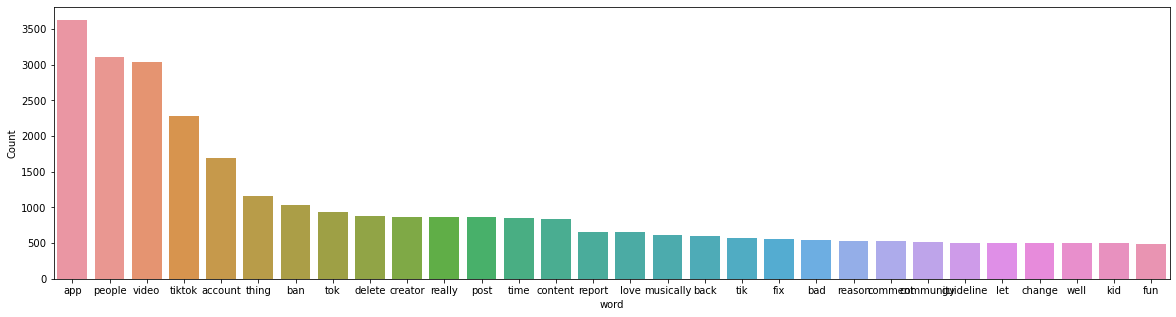

In [103]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_us_ready_score1N2N3))


In [104]:
# Create Dictionary
id2word_us_score1N2N3 = corpora.Dictionary(review_us_ready_score1N2N3)

In [105]:
# Create Corpus: Term Document Frequency
corpus_us_score1N2N3 = [id2word_us_score1N2N3.doc2bow(text) for text in review_us_ready_score1N2N3]

In [106]:
# Training LDA model
model_list_us_score1N2N3, coherence_values_us_score1N2N3 = compute_coherence_values(dictionary=id2word_us_score1N2N3, corpus=corpus_us_score1N2N3, 
                                                              texts=review_us_ready_score1N2N3, limit=30, start=2, step=5)


In [107]:
%store model_list_us_score1N2N3
%store coherence_values_us_score1N2N3

Stored 'model_list_us_score1N2N3' (list)
Stored 'coherence_values_us_score1N2N3' (list)


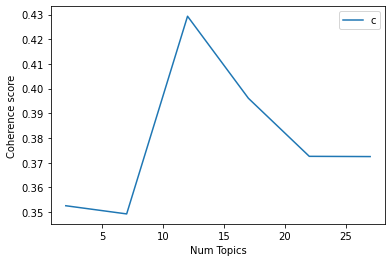

In [108]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [109]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 12

index: 0 | Num Topics = 2  has Coherence Value of 0.3526
index: 1 | Num Topics = 7  has Coherence Value of 0.3493
index: 2 | Num Topics = 12  has Coherence Value of 0.4293
index: 3 | Num Topics = 17  has Coherence Value of 0.3961
index: 4 | Num Topics = 22  has Coherence Value of 0.3726
index: 5 | Num Topics = 27  has Coherence Value of 0.3725


In [183]:
# Select optimal number of topics
optimal_model_us_score1N2N3 = model_list_us_score1N2N3[2]

In [184]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_us_score1N2N3, corpus_us_score1N2N3, id2word_us_score1N2N3)

In [185]:
print("pyLDAVis for us topics for score=1,2,3:")
vis_us_score1N2N3

pyLDAVis for us topics for score=1,2,3:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.185523  0.078967       1        1  25.777865
9      0.225086 -0.048486       2        1  23.812255
2      0.262443  0.001022       3        1  22.502631
5      0.159583  0.066969       4        1   9.037057
4      0.205458 -0.083955       5        1   9.008181
0     -0.072594 -0.284237       6        1   3.039376
10    -0.030429  0.198187       7        1   2.669490
1     -0.135938  0.025010       8        1   1.931661
3     -0.139999  0.020083       9        1   1.134759
7     -0.222963  0.011258      10        1   0.491031
8     -0.222209  0.009255      11        1   0.353623
11    -0.213962  0.005926      12        1   0.242073, topic_info=           Term         Freq        Total Category  logprob  loglift
996         tok   825.000000   825.000000  Default  30.0000  30.0000
87        video  2965.000000  2965.000000  Default  29.0000  29.0000
995         tik   505.000000   505.000000  Default  28.0000  28.0000
481      report   651.000000   651.000000  Default  27.0000  27.0000
1220  guideline   486.000000   486.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1969    pressed     0.730983     4.285162  Topic12  -5.9037   4.2552
3180        cop     0.732110     4.550218  Topic12  -5.9022   4.1967
1035       info     0.938575    23.940789  Topic12  -5.6537   2.7847
572        name     0.789941   114.787239  Topic12  -5.8261   1.0448
1229    provide     0.628448    20.201728  Topic12  -6.0548   2.5534

[776 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1124      9  0.648681    abide
1317      1  0.164284  ability
1317      2  0.164284  ability
1317      3  0.098571  ability
1317      6  0.459996  ability
...     ...       ...      ...
274       4  0.119335      yet
274       7  0.110811      yet
512       1  0.184626    young
512       2  0.791946    young
512       3  0.019434    young

[1503 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 10, 3, 6, 5, 1, 11, 2, 4, 8, 9, 12])

# By-rating of each year

## By-rating of 2018 (Rating=1,2,3)

In [113]:
# By-rating Topic Modelling - rating = 1,2,3 in 2018
# Convert to list - move to each section
review_us_2018_score1N2N3 = tiktok_ios_us_review_YearMonth_2018_score1N2N3.review.values.tolist()
review_words_us_2018_score1N2N3 = list(sent_to_words(review_us_2018_score1N2N3))
print(review_words_us_2018_score1N2N3[:1])

[['ve', 'been', 'using', 'this', 'app', 'for', 'almost', 'years', 'now', 'the', 'new', 'update', 'that', 'just', 'came', 'out', 'doesn', 'let', 'us', 'as', 'muser', 'save', 'our', 'audios', 'to', 'use', 'them', 'later', 'and', 'many', 'others', 'think', 'that', 'you', 'should', 'change', 'it', 'back', 'to', 'what', 'it', 'was', 'or', 'give', 'us', 'the', 'opportunity', 'to', 'save', 'audios', 'and', 'use', 'them', 'later', 'also', 'the', 'way', 'privates', 'are', 'laid', 'out', 'are', 'extremely', 'different', 'from', 'what', 'it', 'used', 'to', 'be', 'so', 'if', 'you', 'could', 'do', 'anything', 'about', 'this', 'really', 'hope', 'you', 'would', 'thank', 'you', 'have', 'couple', 'more', 'things', 'to', 'say', 'in', 'my', 'opinion', 'and', 'probably', 'many', 'others', 'to', 'we', 'don', 'enjoy', 'this', 'new', 'update', 'at', 'all', 'the', 'way', 'everything', 'is', 'laid', 'out', 'is', 'really', 'different', 'am', 'not', 'the', 'biggest', 'fan', 'of', 'it', 'not', 'one', 'that', 'big

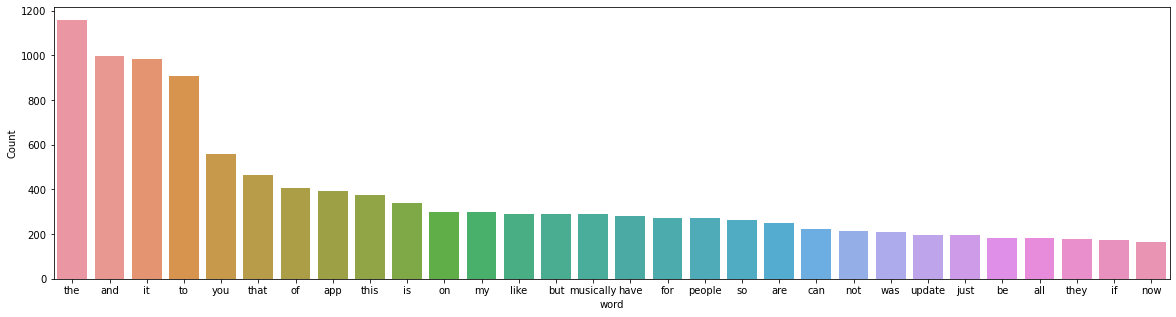

In [114]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_2018_score1N2N3))

In [115]:
# Clean text
review_words_us_ready_2018_score1N2N3 = process_words(review_words_us_2018_score1N2N3)  # processed Text Data! - move to each section

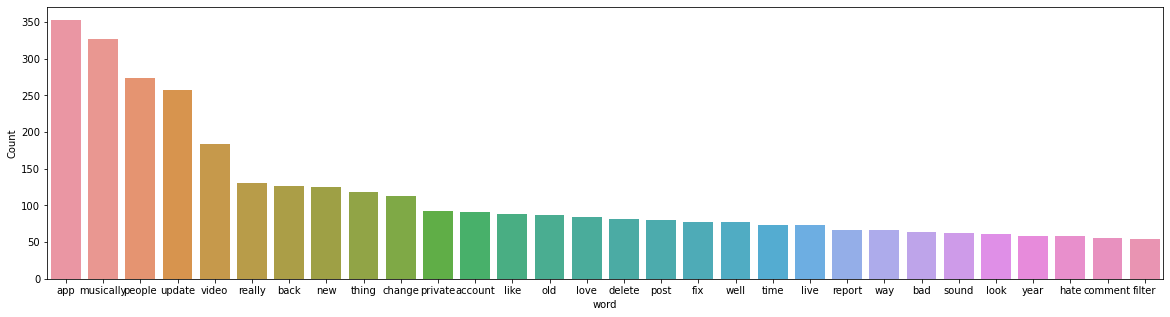

In [116]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_us_ready_2018_score1N2N3))


In [117]:
# Create Dictionary
id2word_us_2018_score1N2N3 = corpora.Dictionary(review_words_us_ready_2018_score1N2N3)

In [118]:
# Create Corpus: Term Document Frequency
corpus_us_2018_score1N2N3 = [id2word_us_2018_score1N2N3.doc2bow(text) for text in review_words_us_ready_2018_score1N2N3]

In [119]:
# Training LDA model
model_list_us_2018_score1N2N3, coherence_values_us_2018_score1N2N3 = compute_coherence_values(dictionary=id2word_us_2018_score1N2N3, corpus=corpus_us_2018_score1N2N3, 
                                                              texts=review_words_us_ready_2018_score1N2N3, limit=30, start=2, step=5)


In [120]:
%store model_list_us_2018_score1N2N3
%store coherence_values_us_2018_score1N2N3

Stored 'model_list_us_2018_score1N2N3' (list)
Stored 'coherence_values_us_2018_score1N2N3' (list)


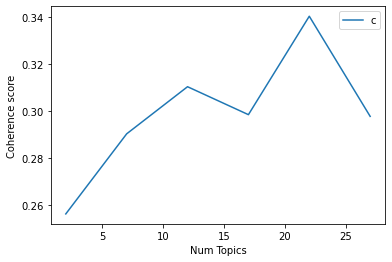

In [121]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_2018_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [122]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_2018_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 22

index: 0 | Num Topics = 2  has Coherence Value of 0.2564
index: 1 | Num Topics = 7  has Coherence Value of 0.2904
index: 2 | Num Topics = 12  has Coherence Value of 0.3103
index: 3 | Num Topics = 17  has Coherence Value of 0.2985
index: 4 | Num Topics = 22  has Coherence Value of 0.3402
index: 5 | Num Topics = 27  has Coherence Value of 0.2978


In [186]:
# Select optimal number of topics
optimal_model_us_2018_score1N2N3 = model_list_us_2018_score1N2N3[4]

In [187]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_2018_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_us_2018_score1N2N3, corpus_us_2018_score1N2N3, id2word_us_2018_score1N2N3)

In [188]:
print("pyLDAVis for us topics for score=1,2,3 in 2018:")
vis_us_2018_score1N2N3

pyLDAVis for us topics for score=1,2,3 in 2018:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13     0.128815 -0.011172       1        1  20.076658
12     0.184230 -0.019664       2        1  16.943864
3      0.168306  0.044920       3        1   7.811554
1      0.046256  0.074035       4        1   7.341255
7      0.094194 -0.065879       5        1   6.993486
20     0.062891  0.051260       6        1   4.965715
2      0.135364 -0.018456       7        1   4.834219
21    -0.051768  0.264984       8        1   4.457522
4      0.070467 -0.043472       9        1   4.204763
5      0.097366 -0.090619      10        1   4.159096
0     -0.022961  0.009675      11        1   3.007238
11    -0.062857  0.033923      12        1   2.247007
18    -0.042708  0.056519      13        1   2.120761
14    -0.033168  0.012325      14        1   2.116275
16    -0.012502 -0.029266      15        1   1.767804
8     -0.044213 -0.039401      16        1   1.530748
6     -0.121094 -0.040335      17        1   1.520503
9      0.006411 -0.063048      18        1   1.340249
17    -0.089530 -0.001433      19        1   1.192738
10    -0.146022  0.008013      20        1   0.662311
15    -0.200390 -0.077594      21        1   0.631502
19    -0.167088 -0.055316      22        1   0.074732, topic_info=          Term        Freq       Total Category  logprob  loglift
57   musically  298.000000  298.000000  Default  30.0000  30.0000
87       video  161.000000  161.000000  Default  29.0000  29.0000
481     report   58.000000   58.000000  Default  28.0000  28.0000
27     private   85.000000   85.000000  Default  27.0000  27.0000
61      people  247.000000  247.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
228  offensive    0.004821    7.964318  Topic22  -7.3505  -0.2107
343   whenever    0.004821   11.223046  Topic22  -7.3505  -0.5537
39      delete    0.004821   72.675173  Topic22  -7.3505  -2.4218
14        give    0.004821   20.618340  Topic22  -7.3505  -1.1620
136     filter    0.004821   49.525734  Topic22  -7.3505  -2.0383

[1380 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1124     14  0.659730  abide
313       1  0.228430   able
313       2  0.182744   able
313       5  0.091372   able
313       6  0.091372   able
...     ...       ...    ...
739       2  0.290703  youth
739       6  0.581407  youth
386      13  0.281091   zoom
386      17  0.281091   zoom
386      18  0.281091   zoom

[2531 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 13, 4, 2, 8, 21, 3, 22, 5, 6, 1, 12, 19, 15, 17, 9, 7, 10, 18, 11, 16, 20])

## By-rating of 2019 (Rating=1,2,3)

In [126]:
# By-rating Topic Modelling - rating = 1,2,3 in 2019
# Convert to list - move to each section
review_us_2019_score1N2N3 = tiktok_ios_us_review_YearMonth_2019_score1N2N3.review.values.tolist()
review_words_us_2019_score1N2N3 = list(sent_to_words(review_us_2019_score1N2N3))
print(review_words_us_2019_score1N2N3[:1])

[['can', 'go', 'live', 'heard', 'it', 'was', 'suppose', 'to', 'be', 'because', 'you', 'have', 'to', 'have', 'but', 'have', 'many', 'friends', 'under', 'that', 'and', 'they', 'do', 'often', 'the', 'thing', 'is', 'the', 'button', 'doesn', 'even', 'exist', 'on', 'my', 'screen', 'and', 'it', 'does', 'on', 'there', 'they', 'said', 'this', 'was', 'because', 'was', 'doing', 'an', 'audio', 'recording', 'and', 'wasn', 'at', 'all', 'the', 'button', 'simply', 'doesn', 'exist', 'and', 'have', 'really', 'been', 'wanting', 'to', 'go', 'live', 'and', 'have', 'that', 'experience', 'no', 'matter', 'the', 'number', 'of', 'fans', 'hav', 'ethelred', 'fans', 'and', 'want', 'to', 'be', 'able', 'to', 'thank', 'them', 'for', 'their', 'support', 'and', 'can', 'because', 'the', 'button', 'doesn', 'exist', 'have', 'the', 'latest', 'version', 'idk', 'have', 'an', 'iphone', 'it', 'just', 'isn', 'an', 'option', 'for', 'some', 'reason', 'disappointing', 'tbh', 'hope', 'this', 'can', 'be', 'fixed', 'because', 'know',

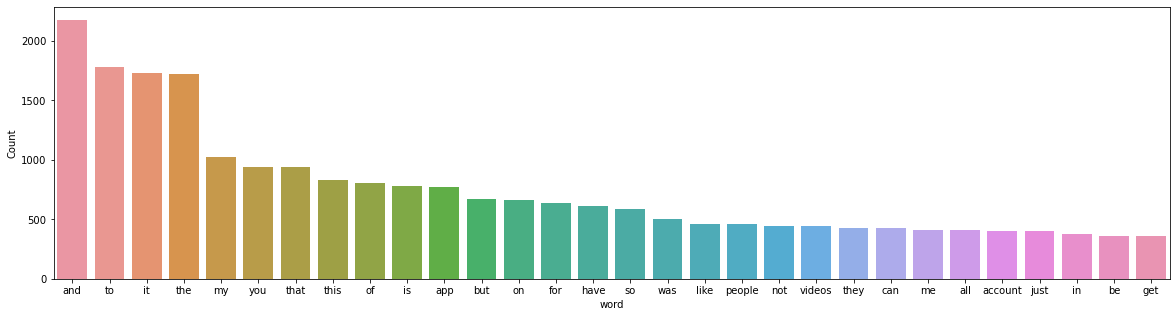

In [127]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_2019_score1N2N3))

In [128]:
# Clean text
review_words_us_ready_2019_score1N2N3 = process_words(review_words_us_2019_score1N2N3)  # processed Text Data! - move to each section

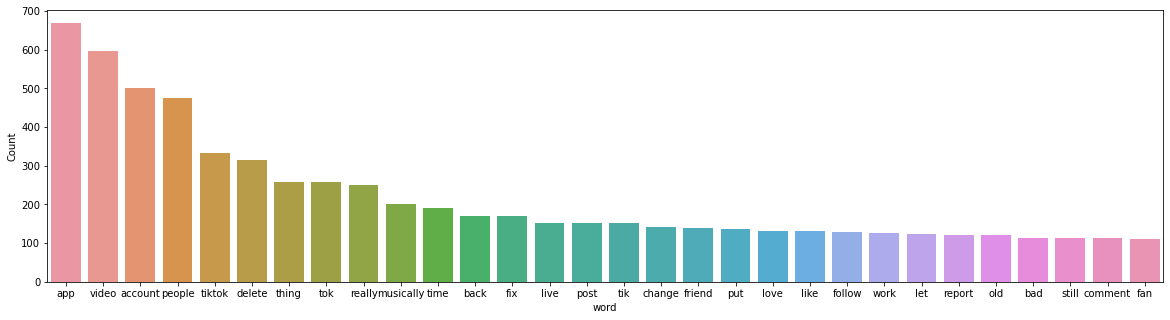

In [129]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_us_ready_2019_score1N2N3))


In [130]:
# Create Dictionary
id2word_us_2019_score1N2N3 = corpora.Dictionary(review_words_us_ready_2019_score1N2N3)

In [131]:
# Create Corpus: Term Document Frequency
corpus_us_2019_score1N2N3 = [id2word_us_2019_score1N2N3.doc2bow(text) for text in review_words_us_ready_2019_score1N2N3]

In [132]:
# Training LDA model
model_list_us_2019_score1N2N3, coherence_values_us_2019_score1N2N3 = compute_coherence_values(dictionary=id2word_us_2019_score1N2N3, corpus=corpus_us_2019_score1N2N3, 
                                                              texts=review_words_us_ready_2019_score1N2N3, limit=30, start=2, step=5)


In [133]:
%store model_list_us_2019_score1N2N3
%store coherence_values_us_2019_score1N2N3

Stored 'model_list_us_2019_score1N2N3' (list)
Stored 'coherence_values_us_2019_score1N2N3' (list)


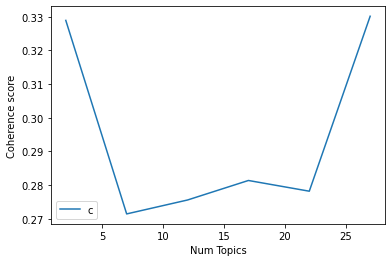

In [134]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_2019_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [135]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_2019_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 2

index: 0 | Num Topics = 2  has Coherence Value of 0.3289
index: 1 | Num Topics = 7  has Coherence Value of 0.2714
index: 2 | Num Topics = 12  has Coherence Value of 0.2756
index: 3 | Num Topics = 17  has Coherence Value of 0.2814
index: 4 | Num Topics = 22  has Coherence Value of 0.2782
index: 5 | Num Topics = 27  has Coherence Value of 0.3302


In [195]:
# Select optimal number of topics
optimal_model_us_2019_score1N2N3 = model_list_us_2019_score1N2N3[5]

In [196]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_2019_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_us_2019_score1N2N3, corpus_us_2019_score1N2N3, id2word_us_2019_score1N2N3)

In [197]:
print("pyLDAVis for us topics for score=1,2,3 in 2019:")
vis_us_2019_score1N2N3

pyLDAVis for us topics for score=1,2,3 in 2019:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
20    -0.140698  0.011119       1        1  34.812436
11    -0.132619  0.180849       2        1   6.818188
4     -0.127296  0.032720       3        1   6.777633
10    -0.116521 -0.055744       4        1   6.036420
15    -0.111118 -0.012949       5        1   4.319667
2     -0.079291 -0.017424       6        1   4.178822
7     -0.025892 -0.070548       7        1   3.542765
8     -0.014843  0.033900       8        1   3.261513
5     -0.079961  0.004691       9        1   3.116335
3     -0.066715 -0.078523      10        1   2.751901
24    -0.034212 -0.001456      11        1   2.559547
22    -0.071725 -0.044401      12        1   2.428629
14     0.075450  0.084793      13        1   2.125292
17     0.010949 -0.082998      14        1   2.101700
19     0.003642 -0.012053      15        1   1.957097
23    -0.024738 -0.007257      16        1   1.835481
21    -0.014304 -0.066297      17        1   1.830676
16     0.049117  0.043073      18        1   1.439345
9      0.007601  0.062711      19        1   1.424380
18     0.006627  0.054137      20        1   1.400055
6      0.017936  0.064633      21        1   1.383229
13     0.034112 -0.062482      22        1   1.350077
0      0.052028 -0.069765      23        1   0.943326
12     0.144805 -0.094470      24        1   0.852237
26     0.184401  0.091056      25        1   0.426567
1      0.238671  0.009181      26        1   0.266379
25     0.214595  0.003504      27        1   0.060305, topic_info=             Term        Freq       Total Category  logprob  loglift
1         account  473.000000  473.000000  Default  30.0000  30.0000
78          video  545.000000  545.000000  Default  29.0000  29.0000
28         really  228.000000  228.000000  Default  28.0000  28.0000
44            app  617.000000  617.000000  Default  27.0000  27.0000
68         people  440.000000  440.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
1         account    0.005457  473.607094  Topic27  -7.7328  -3.9578
2           audio    0.005457   10.412723  Topic27  -7.7328  -0.1405
3          button    0.005457   21.140279  Topic27  -7.7328  -0.8486
4          create    0.005457   21.396406  Topic27  -7.7328  -0.8607
5   disappointing    0.005457    5.595721  Topic27  -7.7328   0.4806

[1837 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
2057     25  0.731418           abb
1789     16  0.617292  abbreviation
1316     15  0.610356      abilitie
0         1  0.167792          able
0         2  0.125844          able
...     ...       ...           ...
223       9  0.026858         young
223      16  0.053716         young
223      18  0.026858         young
223      24  0.026858         young
2121      4  0.580334           zit

[4166 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[21, 12, 5, 11, 16, 3, 8, 9, 6, 4, 25, 23, 15, 18, 20, 24, 22, 17, 10, 19, 7, 14, 1, 13, 27, 2, 26])

## By-rating of 2020 (Rating=1,2,3)

In [139]:
# By-rating Topic Modelling - rating = 1,2,3 in 2020
# Convert to list - move to each section
review_us_2020_score1N2N3 = tiktok_ios_us_review_YearMonth_2020_score1N2N3.review.values.tolist()
review_words_us_2020_score1N2N3 = list(sent_to_words(review_us_2020_score1N2N3))
print(review_words_us_2020_score1N2N3[:1])

[['tried', 'to', 'post', 'new', 'dance', 'video', 'today', 'but', 'immediately', 'after', 'it', 'said', 'my', 'video', 'was', 'under', 'review', 'don', 'wanna', 'anyone', 'to', 'post', 'dance', 'for', 'that', 'song', 'so', 'that', 'was', 'seem', 'original', 'but', 'can', 'even', 'share', 'my', 'video', 'this', 'has', 'happend', 'before', 'and', 'it', 'was', 'an', 'issue', 'with', 'copyright', 'but', 'it', 'wasn', 'just', 'my', 'video', 'it', 'was', 'an', 'audio', 'problem', 'they', 'person', 'to', 'that', 'audio', 'cleared', 'it', 'up', 'and', 'got', 'it', 'put', 'back', 'up', 'the', 'actual', 'songwriter', 'singer', 'of', 'the', 'song', 'is', 'on', 'the', 'app', 'and', 'has', 'used', 'the', 'audio', 'herself', 'and', 'there', 'are', 'other', 'videos', 'up', 'for', 'that', 'sound', 'but', 'it', 'will', 'not', 'let', 'me', 'share', 'mine', 'my', 'video', 'is', 'simply', 'dance', 'and', 'abides', 'by', 'all', 'the', 'other', 'community', 'guidelines', 'so', 'don', 'know', 'what', 'the', 

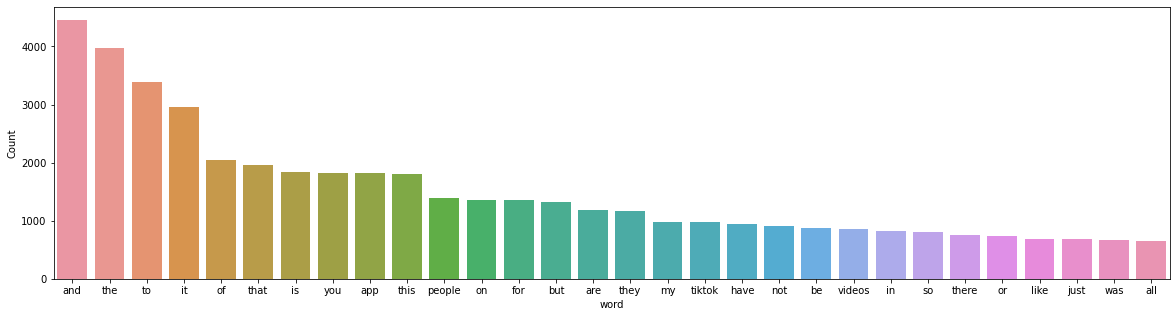

In [140]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_2020_score1N2N3))

In [141]:
# Clean text
review_words_us_ready_2020_score1N2N3 = process_words(review_words_us_2020_score1N2N3)  # processed Text Data! - move to each section

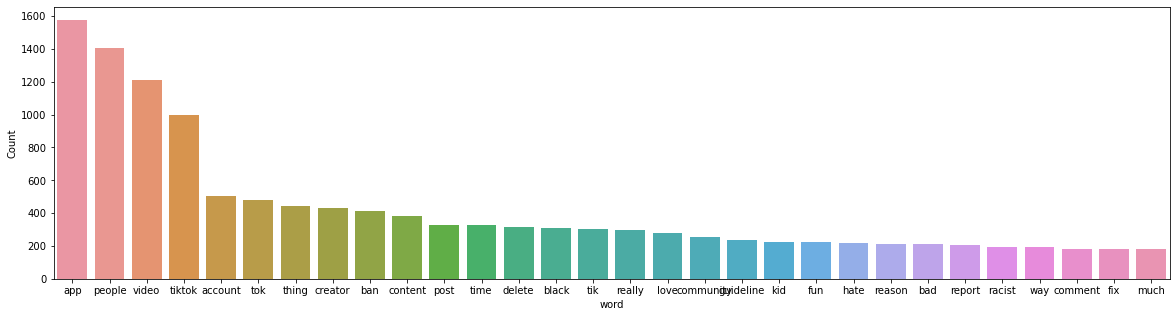

In [142]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_us_ready_2020_score1N2N3))


In [143]:
# Create Dictionary
id2word_us_2020_score1N2N3 = corpora.Dictionary(review_words_us_ready_2020_score1N2N3)

In [144]:
# Create Corpus: Term Document Frequency
corpus_us_2020_score1N2N3 = [id2word_us_2020_score1N2N3.doc2bow(text) for text in review_words_us_ready_2020_score1N2N3]

In [145]:
# Training LDA model
model_list_us_2020_score1N2N3, coherence_values_us_2020_score1N2N3 = compute_coherence_values(dictionary=id2word_us_2020_score1N2N3, corpus=corpus_us_2020_score1N2N3, 
                                                              texts=review_words_us_ready_2020_score1N2N3, limit=30, start=2, step=5)


In [146]:
%store model_list_us_2020_score1N2N3
%store coherence_values_us_2020_score1N2N3

Stored 'model_list_us_2020_score1N2N3' (list)
Stored 'coherence_values_us_2020_score1N2N3' (list)


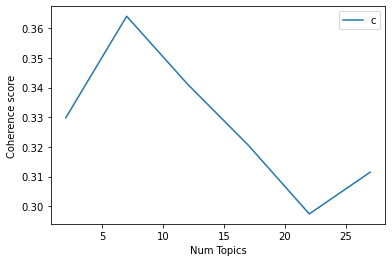

In [147]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_2020_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [148]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_2020_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 7

index: 0 | Num Topics = 2  has Coherence Value of 0.3298
index: 1 | Num Topics = 7  has Coherence Value of 0.364
index: 2 | Num Topics = 12  has Coherence Value of 0.3411
index: 3 | Num Topics = 17  has Coherence Value of 0.3205
index: 4 | Num Topics = 22  has Coherence Value of 0.2974
index: 5 | Num Topics = 27  has Coherence Value of 0.3115


In [198]:
# Select optimal number of topics
optimal_model_us_2020_score1N2N3 = model_list_us_2020_score1N2N3[1]

In [199]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_2020_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_us_2020_score1N2N3, corpus_us_2020_score1N2N3, id2word_us_2020_score1N2N3)

In [200]:
print("pyLDAVis for us topics for score=1,2,3 in 2020:")
vis_us_2020_score1N2N3

pyLDAVis for us topics for score=1,2,3 in 2020:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.098952 -0.057322       1        1  33.747397
0     -0.122163  0.056699       2        1  27.276901
1     -0.082783  0.113828       3        1  18.091821
2     -0.043670 -0.179630       4        1  11.622536
4      0.030382  0.055986       5        1   3.940185
6      0.101441  0.009800       6        1   3.841831
3      0.215744  0.000639       7        1   1.479328, topic_info=          Term         Freq        Total Category  logprob  loglift
32       video  1129.000000  1129.000000  Default  30.0000  30.0000
35     account   469.000000   469.000000  Default  29.0000  29.0000
37         app  1479.000000  1479.000000  Default  28.0000  28.0000
9    guideline   218.000000   218.000000  Default  27.0000  27.0000
4    community   237.000000   237.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
568      whole     1.937580    48.025375   Topic7  -5.8499   1.0033
323   platform     2.091477   102.665193   Topic7  -5.7735   0.3200
149      thing     2.225690   413.283039   Topic7  -5.7113  -1.0105
127      leave     1.879604    57.839353   Topic7  -5.8803   0.7870
559      break     1.806206    42.818517   Topic7  -5.9202   1.0478

[543 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
338       1  0.173068   able
338       2  0.399387   able
338       3  0.053252   able
338       4  0.066565   able
338       5  0.266258   able
...     ...       ...    ...
376       6  0.042020  young
1104      5  0.191668  youth
1104      6  0.575005  youth
1104      7  0.191668  youth
3982      5  0.642981    zoe

[1135 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 2, 3, 5, 7, 4])

## By-rating of 2021 (Rating=1,2,3)

In [152]:
# By-rating Topic Modelling - rating = 1,2,3 in 2021
# Convert to list - move to each section
review_us_2021_score1N2N3 = tiktok_ios_us_review_YearMonth_2021_score1N2N3.review.values.tolist()
review_words_us_2021_score1N2N3 = list(sent_to_words(review_us_2021_score1N2N3))
print(review_words_us_2021_score1N2N3[:1])

[['think', 'everyone', 'should', 'be', 'able', 'to', 'go', 'live', 'you', 'shouldnt', 'have', 'to', 'get', 'like', 'followers', 'just', 'to', 'go', 'live', 'also', 'every', 'time', 'go', 'on', 'tik', 'tok', 'the', 'same', 'two', 'vids', 'are', 'always', 'the', 'first', 'twin', 'on', 'my', 'fyp', 'and', 'it', 'asks', 'me', 'every', 'time', 'to', 'do', 'the', 'select', 'your', 'interests', 'thing', 'also', 'think', 'private', 'accounts', 'should', 'still', 'be', 'able', 'to', 'pop', 'up', 'on', 'the', 'fyp', 'but', 'they', 'can', 'only', 'request', 'to', 'follow', 'them', 'when', 'they', 'click', 'on', 'them', 'they', 'can', 'see', 'their', 'vids', 'unless', 'they', 'follow', 'them', 'another', 'thing', 'love', 'how', 'smaller', 'accounts', 'are', 'coming', 'up', 'on', 'the', 'fyp', 'more', 'but', 'something', 'you', 'should', 'add', 'is', 'making', 'video', 'and', 'making', 'like', 'group', 'of', 'people', 'can', 'see', 'it', 'like', 'if', 'make', 'vid', 'and', 'only', 'want', 'people',

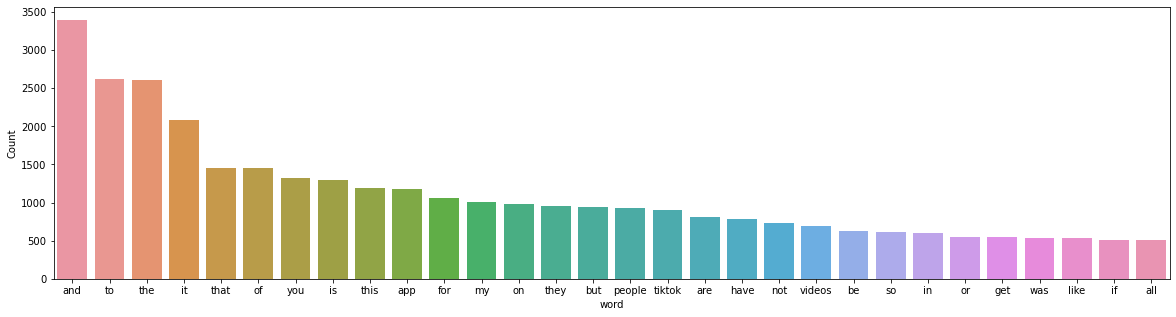

In [153]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_2021_score1N2N3))

In [154]:
# Clean text
review_words_us_ready_2021_score1N2N3 = process_words(review_words_us_2021_score1N2N3)  # processed Text Data! - move to each section

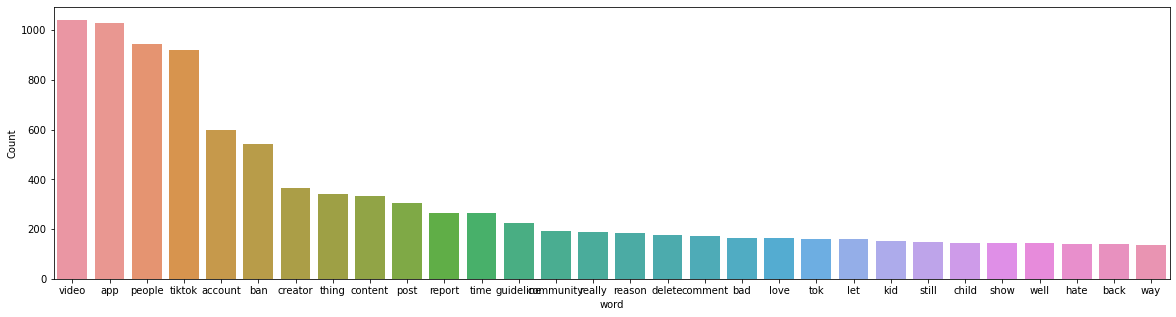

In [155]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_us_ready_2021_score1N2N3))


In [156]:
# Create Dictionary
id2word_us_2021_score1N2N3 = corpora.Dictionary(review_words_us_ready_2021_score1N2N3)

In [157]:
# Create Corpus: Term Document Frequency
corpus_us_2021_score1N2N3 = [id2word_us_2021_score1N2N3.doc2bow(text) for text in review_words_us_ready_2021_score1N2N3]

In [158]:
# Training LDA model
model_list_us_2021_score1N2N3, coherence_values_us_2021_score1N2N3 = compute_coherence_values(dictionary=id2word_us_2021_score1N2N3, corpus=corpus_us_2021_score1N2N3, 
                                                              texts=review_words_us_ready_2021_score1N2N3, limit=30, start=2, step=5)


In [159]:
%store model_list_us_2021_score1N2N3
%store coherence_values_us_2021_score1N2N3

Stored 'model_list_us_2021_score1N2N3' (list)
Stored 'coherence_values_us_2021_score1N2N3' (list)


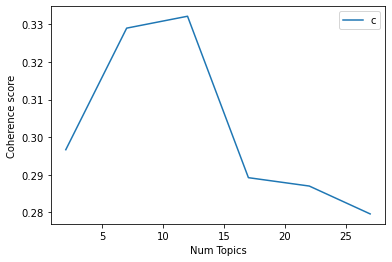

In [160]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_2021_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [161]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_2021_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 12

index: 0 | Num Topics = 2  has Coherence Value of 0.2967
index: 1 | Num Topics = 7  has Coherence Value of 0.329
index: 2 | Num Topics = 12  has Coherence Value of 0.3322
index: 3 | Num Topics = 17  has Coherence Value of 0.2892
index: 4 | Num Topics = 22  has Coherence Value of 0.287
index: 5 | Num Topics = 27  has Coherence Value of 0.2796


In [201]:
# Select optimal number of topics
optimal_model_us_2021_score1N2N3 = model_list_us_2021_score1N2N3[2]

In [202]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_2021_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_us_2021_score1N2N3, corpus_us_2021_score1N2N3, id2word_us_2021_score1N2N3)

In [203]:
print("pyLDAVis for us topics for score=1,2,3 in 2021:")
vis_us_2021_score1N2N3

pyLDAVis for us topics for score=1,2,3 in 2021:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.139383  0.028573       1        1  33.742690
4      0.110380  0.029983       2        1  18.326110
1      0.118764  0.079008       3        1  10.546725
6      0.102546 -0.144813       4        1  10.145156
7      0.073173 -0.031277       5        1   8.757054
5      0.061327  0.074925       6        1   7.390674
10    -0.009024 -0.112376       7        1   3.171226
11    -0.032957  0.057384       8        1   3.068698
3     -0.145201 -0.079560       9        1   1.620809
0     -0.150711  0.048603      10        1   1.214362
8     -0.103336  0.010841      11        1   1.196463
2     -0.164345  0.038708      12        1   0.820034, topic_info=          Term        Freq       Total Category  logprob  loglift
66         app  940.000000  940.000000  Default  30.0000  30.0000
16      people  865.000000  865.000000  Default  29.0000  29.0000
69     content  300.000000  300.000000  Default  28.0000  28.0000
37     creator  339.000000  339.000000  Default  27.0000  27.0000
42   guideline  209.000000  209.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
149       show    1.160161  132.874036  Topic12  -5.4957   0.0627
73        find    1.076884   91.552344  Topic12  -5.5702   0.3607
252   platform    1.048256   77.001284  Topic12  -5.5971   0.5069
24       thing    1.126146  318.688106  Topic12  -5.5254  -0.8418
122     report    1.056737  248.606891  Topic12  -5.5890  -0.6571

[907 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         1  0.357243   able
0         2  0.282818   able
0         3  0.044655   able
0         5  0.133966   able
0         6  0.119081   able
...     ...       ...    ...
675       6  0.221986  young
675       7  0.060542  young
675       8  0.060542  young
675       9  0.020181  young
1114      6  0.775200    zis

[2174 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 5, 2, 7, 8, 6, 11, 12, 4, 1, 9, 3])

# Export pyLDAvis as html

In [204]:
# Overall
pyLDAvis.save_html(vis_us,'vis_us.html')

# By-rating 
pyLDAvis.save_html(vis_us_score1,'vis_us_score1.html')
pyLDAvis.save_html(vis_us_score2,'vis_us_score2.html')
pyLDAvis.save_html(vis_us_score3,'vis_us_score3.html')
pyLDAvis.save_html(vis_us_score4,'vis_us_score4.html')
pyLDAvis.save_html(vis_us_score5,'vis_us_score5.html')
pyLDAvis.save_html(vis_us_score1N2N3,'vis_us_score1N2N3.html')

# By-rating of each year
pyLDAvis.save_html(vis_us_2021_score1N2N3,'vis_us_2021_score1N2N3.html')
pyLDAvis.save_html(vis_us_2020_score1N2N3,'vis_us_2020_score1N2N3.html')
pyLDAvis.save_html(vis_us_2019_score1N2N3,'vis_us_2019_score1N2N3.html')
pyLDAvis.save_html(vis_us_2018_score1N2N3,'vis_us_2018_score1N2N3.html')

